## Time Spent on a Single Task

We start off in the same way as we did for measuring Task Completion. First create a Database Manager instance, and then define the Task and grab Sessions from the Database

In [1]:
# set up paths
from os import pardir, getcwd
from os.path import join, abspath
import sys
nb_dir = getcwd()
project_path = abspath(join(nb_dir, pardir))
sys.path.append(project_path)
# 3rd party imports
import matplotlib.pyplot as plt
from pandas import Series
from tqdm import tqdm
# ux imports
from ux.calcs.time_on_task import time_on_task
from ux.plots.time_on_task import plot_task_completion_times
# local imports
from managers.card_view_manager import CardViewManager
from paths.files import FN_INTERIM_CARD_VIEW
from pmi_examples.helpers import create_card_view_task
from pmi_examples.helpers import create_all_card_view_tasks

In [2]:
# set up db manager
db = CardViewManager(data=FN_INTERIM_CARD_VIEW)
# create task
task = create_card_view_task(
    db=db, search_text='critical-pm-relationships',
    task_name='Critical PM Relationships'
)
# get sessions from database
sessions = db.sessions()

Now we just have to iterate through the Sessions, get the corresponding Action Sequences, and cross reference them against our Task. If the Sequence Actions intersect with the Task's Action Templates, then we add the time the User spent to a list.

In [3]:
task_times = []
for session in tqdm(sessions):
    sequence = db.get_session_sequence(session.session_id)
    if not sequence.intersects_task(task):
        continue
    task_times.append(time_on_task(task=task, action_sequence=sequence).total_seconds())

100%|██████████| 1191/1191 [00:10<00:00, 116.88it/s]


Now we have the list of times, we convert it to a pandas Series, filter it to remove times > 1800s (assuming a max session length of half an hour)

In [4]:
task_times = Series(task_times)
task_times = task_times[task_times <= 1800]
task_times.head()

0     15.037
1      0.950
2    526.783
3      9.624
4     29.789
dtype: float64

Now we have what looks like a sensible result, let's plot its distribution.

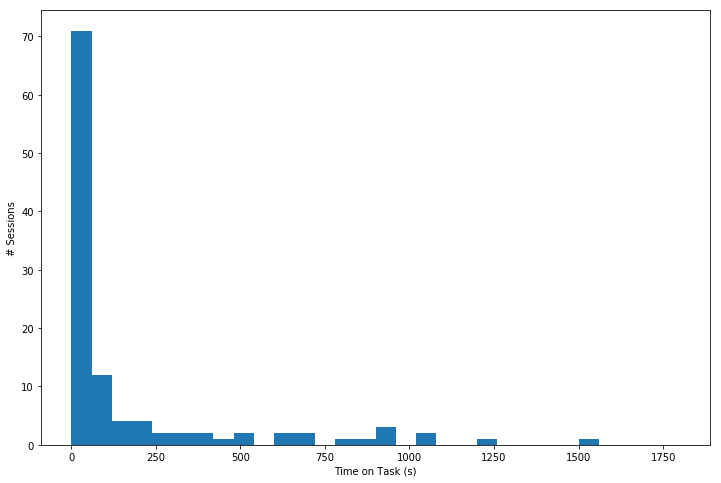

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
task_times.plot(kind='hist', bins=range(0, 1801, 60), ax=ax)
ax.set_xlabel('Time on Task (s)')
ax.set_ylabel('# Sessions')
plt.show()

### Time Spent on Multiple Tasks 

As we saw with Task Completion, working with multiple Tasks just involves defining more of them upfront, and modifications to our iteration and plot code. Let's start by defining the Tasks using a predefined function.

In [6]:
tasks = create_all_card_view_tasks(db=db)

In [7]:
tasks

[Task(Blend Agile and Waterfall [6]),
 Task(Critical PM Relationships [49]),
 Task(Gathering Requirements [50]),
 Task(Personal Kanban [6]),
 Task(Retrospectives [6]),
 Task(Risk Management [52]),
 Task(Scheduling [73]),
 Task(Work Breakdown Structure [6])]

Now pick a suitable data structure:

In [9]:
from collections import defaultdict
task_times = defaultdict(list)

Iterate over session sequences:

In [10]:
for session in tqdm(sessions, desc='Scanning sessions'):
    sequence = db.get_session_sequence(session.session_id)
    for task in tasks:
        if not sequence.intersects_task(task):
            continue
        time_taken = time_on_task(task=task, action_sequence=sequence).total_seconds()
        if 0 < time_taken < 1800:  # ignore random clicks on a single task
            task_times[task.name].append(time_taken)

Scanning sessions: 100%|██████████| 1191/1191 [00:11<00:00, 100.79it/s]


and plot:

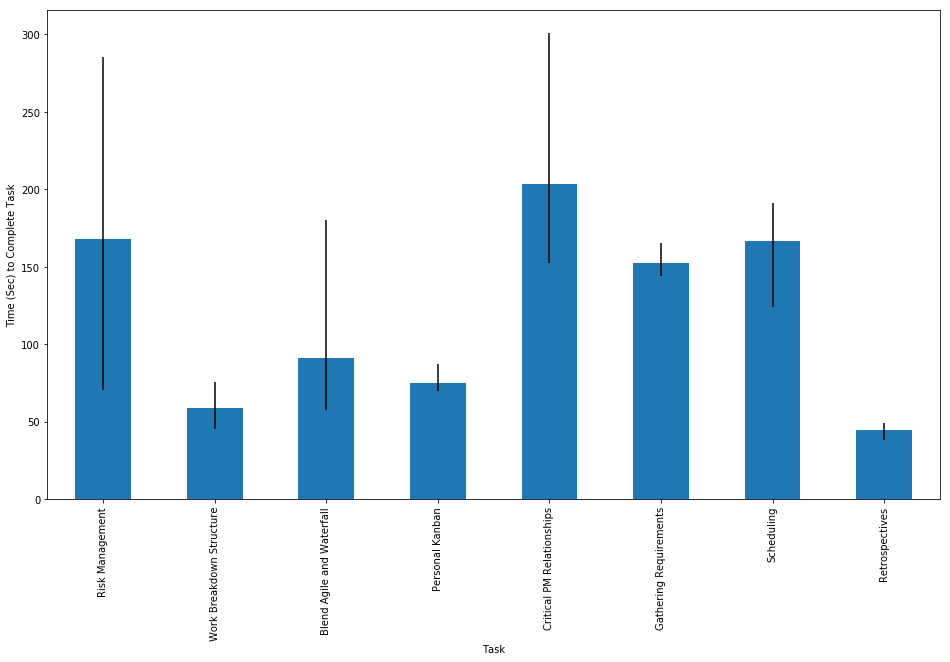

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_task_completion_times(task_times=task_times, confidence=0.68, ax=ax)

This chart gives us a comparison of the different average completion times for each Task, plus an indication of the Confidencee we can have in each average based on the sample size for that Task.